In [21]:
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import torch

In [22]:
def plot_predictions_and_ground_truth(image_path, pred_bboxes, gt_bboxes, yolo_predictions, img_num, slice_num):
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file does not exist: {image_path}")
    
    try:
        image = Image.open(image_path)
        image = np.array(image)
    except Exception as e:
        raise IOError(f"Error reading the image: {e}")
    
    if len(image.shape) == 2:
        image = np.stack((image,) * 3, axis=-1)
    height, width = image.shape[:2]
    
    # Channel names
    channel_names = ['T1', 'T2', 'T2S']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for channel_idx, channel_name in enumerate(channel_names):
        channel = image[:, :, channel_idx]
        
        # Plot image
        ax = axes[channel_idx]
        ax.imshow(channel, cmap='gray')
        ax.axis('off')
        
        # Draw prediction bounding boxes
        for pred in yolo_predictions:
            if pred['image_id'] == f"{img_num}_{slice_num}":
                category_id = pred['category_id']
                x, y, pred_width, pred_height = pred['bbox']
                
                # Only include predictions with non-zero bounding boxes
                if pred_width > 0 and pred_height > 0:
                    if category_id == 0:
                        # Blue for category 1
                        rect = plt.Rectangle((x, y), pred_width, pred_height,
                                           linewidth=1.5, edgecolor='blue', facecolor='none', 
                                           linestyle='-')
                        ax.add_patch(rect)
                    elif category_id == 2:
                        # White for category 2
                        rect = plt.Rectangle((x, y), pred_width, pred_height,
                                           linewidth=0.5, edgecolor='pink', facecolor='none', 
                                           linestyle='-')
                        ax.add_patch(rect)
        
        # Draw ground truth bounding boxes
        for bbox in gt_bboxes:
            class_id, x_center, y_center, gt_width, gt_height = bbox
            center_x = int(x_center * width)
            center_y = int(y_center * height)
            
            patch_size_w = gt_width * width
            patch_size_h = gt_height * height
            
            x_min = center_x - patch_size_w // 2
            y_min = center_y - patch_size_h // 2
            
            if class_id == 0:
                # Red for class 0
                rect = plt.Rectangle((x_min, y_min), patch_size_w, patch_size_h,
                                   linewidth=1, edgecolor='red', facecolor='none',
                                   linestyle='-')
                ax.add_patch(rect)
            # elif class_id == 1:
            #     # Pink for class 1
            #     rect = plt.Rectangle((x_min, y_min), patch_size_w, patch_size_h,
            #                        linewidth=1, edgecolor='green', facecolor='none',
            #                        linestyle='-')
            #     ax.add_patch(rect)
    
    # Create legend with correct colors
    if pred_bboxes or gt_bboxes:
        from matplotlib.patches import Patch
        legend_elements = []
        
        # Add prediction legend entries
        # if any(pred['category_id'] == 1 for pred in yolo_predictions if pred['image_id'] == f"sub-{img_num}_slice_{slice_num}"):
        legend_elements.append(Patch(facecolor='none', edgecolor='blue', linewidth=1, label='CMB-Pred'))
        # if any(pred['category_id'] == 2 for pred in yolo_predictions if pred['image_id'] == f"sub-{img_num}_slice_{slice_num}"):
        # legend_elements.append(Patch(facecolor='none', edgecolor='pink', linewidth=1, label='CSF-Pred'))
        
        # Add ground truth legend entries
        # if any(bbox[0] == 0 for bbox in gt_bboxes):
        legend_elements.append(Patch(facecolor='none', edgecolor='red', linewidth=1, label='CMB-GT'))
        # if any(bbox[0] == 1 for bbox in gt_bboxes):
        #     legend_elements.append(Patch(facecolor='none', edgecolor='green', linewidth=1, label='CSF-GT'))
        
        if legend_elements:
            fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.95))
    
    plt.tight_layout()
    plt.show()

def visualize_predictions_and_ground_truth(root_path, img_num, slice_num, yolo_predictions, task):
    """
    Visualize both YOLO predictions and ground truth on the same image
    
    Args:
        root_path: Root path to the dataset
        img_num: Image number (e.g., "110")
        slice_num: Slice number (e.g., "030")
        yolo_predictions: List of YOLO prediction dictionaries
    """
    # Construct paths
    label_path = f"{root_path}/labels/{task}/{img_num}_{slice_num}.txt"
    image_path = label_path.replace("labels", "images").replace("txt", "png")
    image_id = f"sub-{img_num}_slice_{slice_num}"
    
    try:
        # Load ground truth bounding boxes
        gt_bboxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as txt_file:
                gt_bboxes = [list(map(float, line.split())) for line in txt_file.readlines()]
        
        # Filter predictions for this specific image
        pred_bboxes = []
        for pred in yolo_predictions:
            if pred['image_id'] == image_id:
                bbox = pred['bbox']
                # Only include predictions with non-zero bounding boxes
                if bbox[2] > 0 and bbox[3] > 0:  # width and height > 0
                    pred_bboxes.append(bbox)
        
        # Plot both predictions and ground truth
        plot_predictions_and_ground_truth(image_path, pred_bboxes, gt_bboxes, yolo_predictions, img_num, slice_num)
        
        print(f"Image: {image_id}")
        print(f"Ground Truth boxes: {len(gt_bboxes)}")
        print(f"Prediction boxes: {len(pred_bboxes)}")
        
        # Print class distribution
        if gt_bboxes:
            gt_classes = [int(bbox[0]) for bbox in gt_bboxes]
            print(f"GT Class distribution: {dict(zip(*np.unique(gt_classes, return_counts=True)))}")
        
        if yolo_predictions:
            pred_categories = [pred['category_id'] for pred in yolo_predictions if pred['image_id'] == image_id and pred['bbox'][2] > 0 and pred['bbox'][3] > 0]
            if pred_categories:
                print(f"Prediction Category distribution: {dict(zip(*np.unique(pred_categories, return_counts=True)))}")
        
    except Exception as e:
        print(f"An error occurred: {e}")
        try:
            with Image.open(image_path) as img:
                print(f"Image format: {img.format}")
                print(f"Image size: {img.size}")
                print(f"Image mode: {img.mode}")
        except Exception as e:
            print(f"Could not open the image for additional information: {e}")

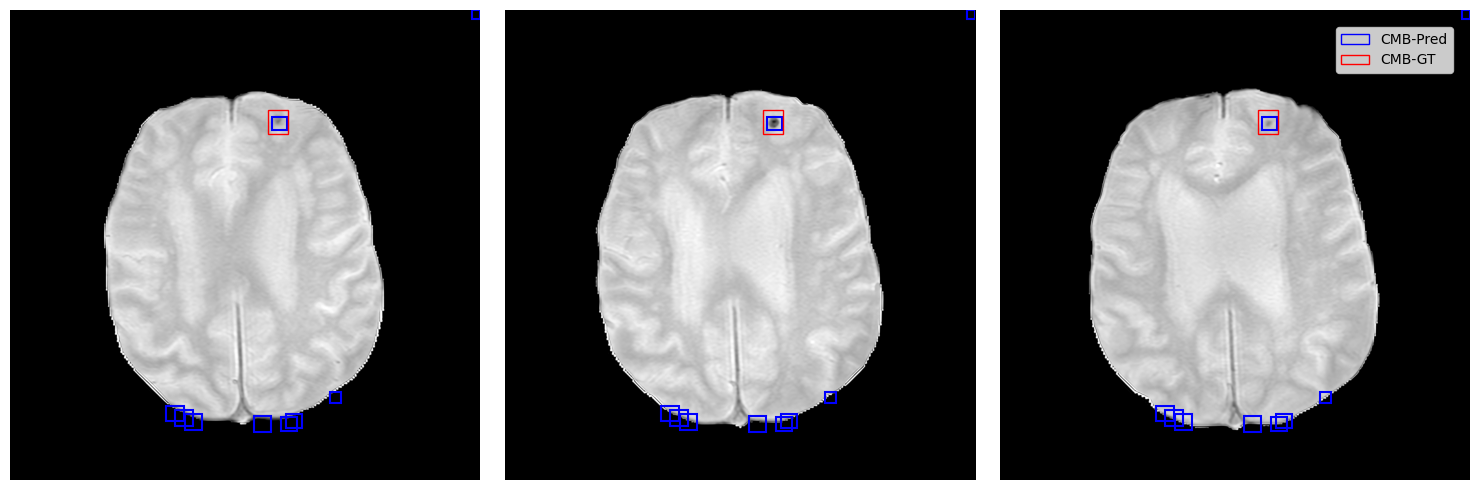

Image: sub-4817777_slice_30
Ground Truth boxes: 1
Prediction boxes: 0
GT Class distribution: {0: 1}


In [23]:
# Your existing YOLO predictions
yolo_output = [
{"image_id": "4817777_30", "category_id": 0, "bbox": [570.796, 231.621, 32.322, 30.353], "score": 0.00476}, {"image_id": "4817777_30", "category_id": 0, "bbox": [1006.14, 0.0, 17.86, 19.084], "score": 0.00037}, {"image_id": "4817777_30", "category_id": 0, "bbox": [380.017, 880.448, 37.586, 33.078], "score": 0.0002}, {"image_id": "4817777_30", "category_id": 0, "bbox": [696.431, 832.658, 25.221, 23.206], "score": 0.00019}, {"image_id": "4817777_30", "category_id": 0, "bbox": [358.939, 871.625, 39.006, 34.074], "score": 0.00018}, {"image_id": "4817777_30", "category_id": 0, "bbox": [340.211, 862.833, 37.516, 32.255], "score": 0.00012}, {"image_id": "4817777_30", "category_id": 0, "bbox": [590.007, 885.627, 34.382, 30.319], "score": 0.00012}, {"image_id": "4817777_30", "category_id": 0, "bbox": [531.198, 884.985, 37.737, 33.663], "score": 0.00011}, {"image_id": "4817777_30", "category_id": 0, "bbox": [601.25, 880.701, 34.122, 29.312], "score": 0.00011}
]
# Your existing parameters
task = "test"
img_num = "4817777"
slice_num = "30"

# 3 slices
root_path = "/media/Datacenter_storage/Ji/brain_mri_valdo_mayo/mayo_yolo_3slices"

# csf
# root_path = "/media/Datacenter_storage/Ji/brain_mri_valdo_mayo/mayo_yolo_all_sequence_csf"

# all sequence
# root_path = "/media/Datacenter_storage/Ji/valdo_dataset/valdo_all_sequence_cmbOnly_GAN"


visualize_predictions_and_ground_truth(root_path, img_num, slice_num, yolo_output, task)

In [24]:
# # Your existing YOLO predictions
# yolo_output = [
#      {"image_id": "sub-110_slice_030", "category_id": 1, "bbox": [1177.81, 1424.656, 37.821, 33.731], "score": 0.02971}, {"image_id": "sub-110_slice_030", "category_id": 1, "bbox": [0.0, 0.0, 0.0, 0.0], "score": 0.00039}, {"image_id": "sub-110_slice_030", "category_id": 1, "bbox": [1283.655, 963.544, 34.491, 31.239], "score": 0.00038}, {"image_id": "sub-110_slice_030", "category_id": 1, "bbox": [1050.92, 593.594, 42.432, 27.441], "score": 0.00029}, {"image_id": "sub-110_slice_030", "category_id": 1, "bbox": [1038.366, 598.553, 34.975, 35.009], "score": 0.00027}, {"image_id": "sub-110_slice_030", "category_id": 1, "bbox": [1232.577, 1308.564, 30.94, 34.216], "score": 0.00012}
# ]

# # Your existing parameters
# task = "val"
# img_num = "110"
# slice_num = "030"

# # csf
# root_path = "/media/Datacenter_storage/Ji/valdo_dataset/valdo_resample_ALFA_YOLO_PNG_epd_gt_box_t2s_GAN_3slices_cmbTrainOnly"

# # all sequence
# # root_path = "/media/Datacenter_storage/Ji/valdo_dataset/valdo_all_sequence_cmbOnly_GAN"

# visualize_predictions_and_ground_truth(root_path, img_num, slice_num, yolo_output, task)